$\newcommand{\ket}[1]{\left|#1\right>}$

$\newcommand{\bra}[1]{\left<#1\right|}$

$\newcommand{\braket}[2]{\left<#1 | #2\right>}$

$\newcommand{\expectation}[1]{\left<#1\right>}$

# The Max Cut Problem

#### References
Qiskit Max Cut tutorial: https://qiskit.org/textbook/ch-applications/qaoa.html <br>
Qiskit VQE tutorial: https://qiskit.org/textbook/ch-applications/vqe-molecules.html <br>
Wikipedia: https://en.wikipedia.org/wiki/Maximum_cut


In [1]:
# To import all the functions defined in the notebook
from  Functions import *

## Problem Definition

Let's consider a non-directed graph with $n$ vertices and $m$ edges.

The Max Cut problems aim to find the two complementary subsets of vertices such that the number of edges connecting vertices of different subsets is maximal.

This can be more easily visualized through an example, so that we can consider a graph G(V,E) with:
- n = 5 vertices: $V = \{V_1, V_2, V_3, V_4, V_5\}$;
- m = 6 edges: $E = \{(0,1),(0,2),(1,2),(3,2),(3,4),(4,2)\}$;
- as we can see below, the graph is organized so that it recalls the shape of a butterfly.

We can use a small piece of code to formalize the graph and show it.

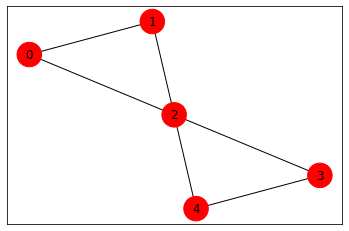

In [1]:
# Tools to handle general graphs
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt 

# Graph parameters 
n = 5
V = np.arange(0,n,1)
#   (v1,v2, weight)
E = [(0, 1, 1.0),
     (0, 2, 1.0),
     (1, 2, 1.0),
     (3, 2, 1.0),
     (3, 4, 1.0),
     (4, 2, 1.0)] 

# Generating the butterfly graph with 5 nodes
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Plot the graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, 
                 node_color = colors, 
                 node_size  = 600, 
                 alpha      = 1, 
                 ax         = default_axes, 
                 pos        = pos)

This is clearly a combinatorial optimization problem, since in principle we should try all the possible compositions of subsets and count the number of edges connecting vertices of different subsets.

We can formalize our problem as a quadratic unconstrained binary optimization problem (QUBO), if we define the two subsets as $V1$ and $V2$ so that:
- the vertices in $V1$ get are assigned a value 0: $x_i = 0 ~\forall~ V_i \in V1$;
- the vertices in $V2$ get are assigned a value 0: $x_i = 1 ~\forall~ V_i \in V2$.

Additionally, we introduce a weight matrix $w_{ij}$ with:
- $w_{ii} = 0$ (a vertex is never connected to itself);
- $w_{ij} = 1$ for existing edges;
- $w_{ij} = 0$ for if vertex $V_i$ and vertex $V_j$ are not connected by any edge;
- $w_{ij} = w_{ji}$.

Thanks to this, we can defined a cost function that we would like to maximize:

$$ C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1 - x_j)$$

where we can see that if two vertices belong to the same subset, the contribution to the cost function is 0 (at least one of the two terms $x_i$ or $(1 - x_j)$ is 0), while for vertices belonging to complementary subsets, the contribution is 1. The fact that $x_i$ must be 1 and $x_j$ must be 0, avoids counting twice the same edge.

A more general approach may introduce different weights for different edges, so that $w_{ij} \neq 1$, but always keeping $w_{ij} > 0$.

## Problem Resolution: Brute Force Approach

Independently on the values of the weights, the problem is $NP$, since testing all the possible combinations of subsets $V1$ and $V2$ requires $2^n - 2$ (all the element in $V1$ or all the element in $V2$ are not valid solutions) evaluations of the cost function.
This approach is called *brute force* and is strongly inefficient, so that it cannot be used even for not-so-large values of n.

We can try and implement such approach in this case and use the results as a cross-check to test alternative ways of solving the problem.

In particular, in order to have just one possible solution, we are going to give all the edges weight 1, but the edges connecting to vertes $V_2$, which will have weight 2.

case = [0, 0, 0, 0, 0] score = 0
case = [1, 0, 0, 0, 0] score = 3
case = [0, 1, 0, 0, 0] score = 3
case = [1, 1, 0, 0, 0] score = 4
case = [0, 0, 1, 0, 0] score = 8
case = [1, 0, 1, 0, 0] score = 7
case = [0, 1, 1, 0, 0] score = 7
case = [1, 1, 1, 0, 0] score = 4
case = [0, 0, 0, 1, 0] score = 3
case = [1, 0, 0, 1, 0] score = 6
case = [0, 1, 0, 1, 0] score = 6
case = [1, 1, 0, 1, 0] score = 7
case = [0, 0, 1, 1, 0] score = 7
case = [1, 0, 1, 1, 0] score = 6
case = [0, 1, 1, 1, 0] score = 6
case = [1, 1, 1, 1, 0] score = 3
case = [0, 0, 0, 0, 1] score = 3
case = [1, 0, 0, 0, 1] score = 6
case = [0, 1, 0, 0, 1] score = 6
case = [1, 1, 0, 0, 1] score = 7
case = [0, 0, 1, 0, 1] score = 7
case = [1, 0, 1, 0, 1] score = 6
case = [0, 1, 1, 0, 1] score = 6
case = [1, 1, 1, 0, 1] score = 3
case = [0, 0, 0, 1, 1] score = 4
case = [1, 0, 0, 1, 1] score = 7
case = [0, 1, 0, 1, 1] score = 7
case = [1, 1, 0, 1, 1] score = 8
case = [0, 0, 1, 1, 1] score = 4
case = [1, 0, 1, 1, 1] score = 3
case = [0,

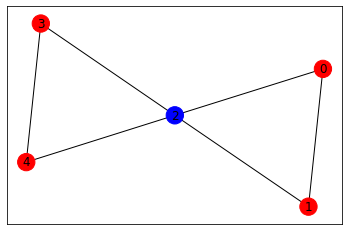

In [2]:
import numpy as np
import networkx as nx

# number of characters
n = 5

# W matrix definition
W = np.array([[0, 1, 2, 0, 0],
              [1, 0, 2, 0, 0],
              [2, 2, 0, 2, 2],
              [0, 0, 2, 0, 1],
              [0, 0, 2, 1, 0]])

best_cost_brute = 0

# computing all possible combinations
for b in range(2**n):
    # x stores all the 2^n possible combinations of 0 and 1
    # for a vector of length n 
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]

    # initialize cost function value
    cost = 0
    # scan all possible costs and keep the highest one
    # (now we want to maximize our score!)
    for i in range(n):
        for j in range(n):
            cost = cost + W[i,j]*x[i]*(1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' score = ' + str(cost))

# Showing results    
colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute)) 

As expected by the way we constructed the problem, the highest score is obtained when $V_2$ is alone in one of the two subsets of $V$.

## Problem Resolution: Ising Hamiltonian

If we want to try and solve the problem more efficiently using a quantum computer, the first step consists in transforming it from a QUBO problem to a Ising Hamiltonian. To get the solution of the problem, we will have to find the fundamental state of the Hamiltonian.

The result is the same (even if we are now going to look for a minimum, instead of a maximum), but this new formalism better adapts to the dual state that a qbit can assume:

$\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$

where $\alpha$ and $\beta$ are complex coefficients that satisfy the relation:

$ |\alpha|^2 + |\beta|^2 = 1 $


To do so, we have to perform some transformations to the original formulation of the problem:
- $x_i \rightarrow 
    \dfrac{1}{2}
    (\mathbb{1} + \sigma_z)_i = 
    \dfrac{1}{2}
    \left[
    \mathbb{1} + 
    \begin{bmatrix}
    1 &  0 \\
    0 & -1
    \end{bmatrix}
    \right]_i = 
    \begin{bmatrix}
    1 & 0 \\
    0 & 0
    \end{bmatrix}_i
    $<br>
    where the operator acts only on the corresponding states and has the following properties:
    - $ \begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}
        \begin{bmatrix}
        1 \\
        0
        \end{bmatrix} = 
        1 \cdot
        \begin{bmatrix}
        1 \\
        0
        \end{bmatrix}$ <br>
        $\begin{bmatrix}
        1 \\
        0
        \end{bmatrix}$ is eigenvector of 
        $\begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}$
        with eigenvalue 1. <br>
        This means that $x_i = 1 \rightarrow         
        \begin{bmatrix}
        1 \\
        0
        \end{bmatrix} = \ket{1}$
    - $ \begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}
        \begin{bmatrix}
        0 \\
        1
        \end{bmatrix} = 
        0 \cdot
        \begin{bmatrix}
        0 \\
        1
        \end{bmatrix}$ <br>
        $\begin{bmatrix}
        0 \\
        1
        \end{bmatrix}$ is eigenvector of 
        $\begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}$
        with eigenvalue 0. <br>
        This means that $x_i = 0 \rightarrow         
        \begin{bmatrix}
        0 \\
        1
        \end{bmatrix} = \ket{0}$

- consequently, we will replace:
$(1 - x_i) \rightarrow 
    \left[
    \mathbb{1} -     
    \begin{bmatrix}
    1 & 0 \\
    0 & 0
    \end{bmatrix}
    \right]_i = 
    \begin{bmatrix}
    0 & 0 \\
    0 & 1
    \end{bmatrix}_i$

- for every entry of the original $n x n$ QUBO matrix, take the entry $(i,j)$ and multiply it by the tensor product from $1$ to $n$ of $2 x 2$ identities, with the excpetion of the $i$-th and $j$-th terms of the product, which are the $2 x 2$ matrices corresponding to $x_i$ and $(1 - x_j)$. The sum of all these products is a diagonal $2^n x 2^n$ matrix, whose entries are the expectation values obtained with the *brute force* algorithm and corresponds to the Ising Hamiltonian associated to the problem. 

Since the process of converting a QUBO problem is not straightforward, let's make it clearer by doing it for the current problem, using a simple function.

In [3]:
# Define the 2x2 matrices we need

# (1 + pauli_z)/2
sigma_z = np.array([[1, 0], [0, 0]])

# (1 - sigma_z)
minus_z = np.array([[0, 0], [0, 1]])

# Identity
id_matrix = np.array([[1, 0], [0, 1]])

In [4]:
# The actual function
def qubo_to_ising(input_Q):
    n = len(input_Q)
    print("input:")
    print(input_Q)
    print("")
    
    # initialize H
    H = 0

    # compute the contribution of the i,j term to the Hamiltonian
    # i = left-side term = x_i (corresponds to sigma_z)
    for i in range(n):
        # j = right-side term = (1 - x_j) (corresponds to minus_z)
        for j in range(n):            
            # first term
            matrix_ij = 0
            if i == 0:
                matrix_ij = sigma_z
            elif j == 0:
                matrix_ij = minus_z
            else:
                matrix_ij = id_matrix
            
            # tensor product n times
            for k in range(1,n):
                if i == k:
                    new_term = sigma_z
                elif j == k:
                    new_term = minus_z
                else:
                    new_term = id_matrix                
                matrix_ij = np.kron(matrix_ij, new_term)

            # multiply by the i,j term of input_Q 
            matrix_ij = matrix_ij * input_Q[i,j]
            
            # sum
            H = H + matrix_ij
    
    return(-H) 

In [5]:
# Translate our QUBO matrix to a Ising Hamiltonian
H = qubo_to_ising(W)

print('Ising Hamiltonian dimensions:' + str(H.shape))
print("")

# Check eigenvalues
print("Ising eigenvalues:")
eigenvalues = []
for i in range(len(H)):
    eigenvalues.append(H[i,i])
print(eigenvalues)    

input:
[[0 1 2 0 0]
 [1 0 2 0 0]
 [2 2 0 2 2]
 [0 0 2 0 1]
 [0 0 2 1 0]]

Ising Hamiltonian dimensions:(32, 32)

Ising eigenvalues:
[0, -3, -3, -4, -8, -7, -7, -4, -3, -6, -6, -7, -7, -6, -6, -3, -3, -6, -6, -7, -7, -6, -6, -3, -4, -7, -7, -8, -4, -3, -3, 0]


## Problem Resolution: Variational Quantum Eigensolver (VQE)

We have seen that the Ising formulation is equivalent to the standard QUBO formulation of optimization problem and we state that it is more suited the resolution on a quantum computer. On the other hand, we still need $2^n$ evaluations of the Hamiltonian if we want to find the optimal solution.

One possible way to exploit quantum computers to try and solve optimization problems more efficiently is through the so-called Variational Quantum Eigensolver (VQE) algorithm.

It exploits the rapidity of a quantum computer in evaluating the cost function for a given quantum state $\ket{\psi}$ and associates it with a classical optimizer that helps in finding the optimal one.

### VQE: basic concepts

To uderstand the idea behind VQE, we start by introducing the concepts of eigenvalue and eigenvector (or eigenstate), defined through the following relation:

$$ H \ket{\psi_i} = \lambda_i \ket{\psi_i}$$

where $H$ is the matrix describing the Hamiltonian, $\lambda_i$ is a eigenvalue and $\ket{\psi_i}$ is a eigenvector.
In our case, the Hamiltonian $H$ is described by a diagonal matrix and the eigenvalues correspond to its diagonal entries and the eigenstates are the vectors:

$$ \ket{\psi_i} = \{ \ket{00000}, \ket{00001}, \ket{00010}, \ket{00011}, ...\} $$

This follows from the fact that in quantum mechanics, the outcome of a measurement can give only a discrete set of results. In particular, this set of results corresponds to the eigenvalues of the Hamiltonian $H$ describing the quantum system that we are measuring and each eigenvalue is associated to one eigenvector, or eigenstate of the system. 

The eigenvectors represent a basis of the space of the possible states of the quantum system, so that a general state $\psi$ can be written as:

$$ \ket{\psi} = \sum_i^N \alpha_i \ket{\psi_i}$$

where in our case $N = 2^n$ is the number of eigenvalues and $\alpha_i$ is the projection of $\ket{\psi}$ on the eigenvector $\ket{\psi_i}$:

$$ \alpha_i = \braket{\psi_i}{\psi} $$

And the Hamiltonian can be expressed as:

$$ H = \sum_i^{N} \lambda_i \ket{\psi_i} \bra{\psi_i}$$

The solution of our problem is the eigenvector associated to the smallest eigenvalue (let's call them $\lambda_{min}$ and $\ket{\psi_{min}}$). 
In general, the outcome of a measurement (or expectation value) is always larger than the one obtained when the system is in the *fundamental state* $\ket{\psi_{min}}$:

$$ \lambda_{min} = \expectation{\psi_{min}|H|\psi_{min}} \leq
\expectation{\psi|H|\psi} = 
\bra{\psi} \left( \sum_i^{N} \lambda_i \ket{\psi_i} \bra{\psi_i} \right) \ket{\psi} = 
\sum_i^{N} \lambda_i \braket{\psi}{\psi_i} \braket{\psi_i}{\psi} = 
\sum_i^{N} \lambda_i |\braket{\psi_i}{\psi}|^2 $$

In other words, a large projection of the current state on the fundamental state, which is our solution, will produce a small expected value.

The idea of VQE is to start with a reasonable ansatz for $\ket{\psi}$ (which for example is a superposition of all the possible eigenstates) and iteratively changing its eigenstate composition, typically through a series of rotations (we call this *optimization*), until we find the optimal solution or until we are satisfied with how close we are to it.

### On the expected value

It is important at this point make that a single measurement gives only one of the possible results allowed.

For example, in our case, if we prepare our state $\ket{\psi}$ such that it corresponds to the case (0, 0, 1, 0, 0), we will get, for every measurement, the result $\lambda_{min} = -8$.
In general, keeping in mind the probabilistic nature of quantum mechanics, a state:

$$ \ket{\psi} = \sum_i^N \alpha_i \ket{\psi_i} $$

will return as result the eigenvalue $\lambda_i$ with probability $| \alpha_i|^2$.

This means that, for every state $\ket{\psi}$ that we consider, several measurements have to be performed in order to have an idea of how *large* or *small* the expected value is.

Moreover, in our simple case we know all the eigenvalues of the Hamiltonian, while in general they may be so many that it is not convenient to explicitly get them, since it would correspond to solve the problem by *brute force*, making the optimization algorithm role even more delicate.

### VQE: Ansatz

First of all, when preparing the ansatz for our solution, we have to consider that we will need one qbit for every vertex of our graph. In our case, we will need $n = 5$ qbits.

Then, we want our ansatz:
- to be able to cover the largest possible number of states $\rightarrow$ more parameters;
- to have a small number of gates: many gates may introduce errors and may make more difficult to converge towards a sensible solution $\rightarrow$ less parameters.

The choice will have to be a trade-off between these two opposite requirements.

Among many possible possibilities, the so-called RY ansatz is quite popular and consists of:
1. put every qbit in the $\ket{+} = \dfrac{\ket{0} + \ket{1}}{\sqrt{2}}$ state through a rotation of $\frac{\pi}{2}$ around the y-axis of its Bloch sphere;
- connect (or introduce entanglement among) different qbits, for example between pair of qbits;
- introduce for each qbit a rotation around the y-axis of its Bloch sphere (RY-gate). The rotation angles are the parameters to be adjusted during the optimization process;
- repeat step 2. and 3. for a chosen number of times, keeping in mind that more RY-gates means more parameters for the optimizer.

The entanglement between two qbits can be obtained by applying a controlled gate, a gate that applies a transformation on a target qbit only if the control qbit is in the $\ket{1}$ state.
In our case, we will apply controlled z-gates.

The RY ansatz is particularly popular since it allows to span a large number of states without introducing any complex phase, thanks to the fact that all the rotations are performed around the y- axis of the Bloch sphere.

Let's try and prepare the ansatz for our problem using qiskit.

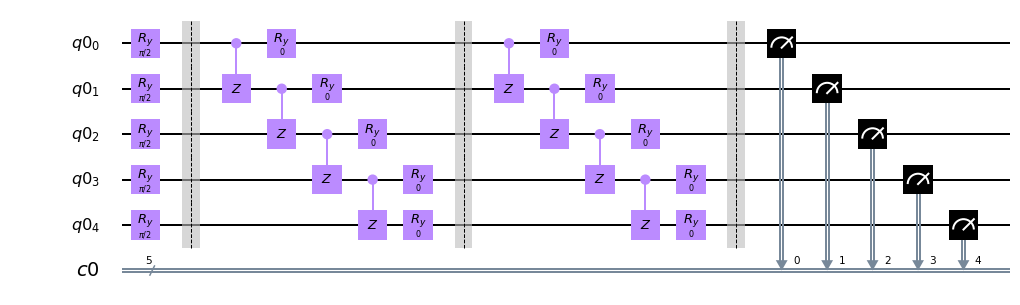

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

PI = np.pi

# Number of qbits
n = 5

# Define the Quantum and Classical Registers
q = QuantumRegister(n)
c = ClassicalRegister(n)

# Build the circuit for the ansatz
circuit = QuantumCircuit(q, c)

# Put all the qbits in the |+> state
theta_hadamard = [PI/2,PI/2,PI/2,PI/2,PI/2]
for i in range(n):
    circuit.ry(theta_hadamard[i],q[i])
circuit.barrier()

# Apply controlled-z gates (first layer)
for i in range(n-1):
    circuit.cz(q[i], q[i+1])

# Introduce RY-gates (first layer)
theta_0 = [0.,0.,0.,0.,0.]
for j in range(n):
    circuit.ry(theta_0[j],q[j])
circuit.barrier()

# Apply controlled-z gates (second layer)
for i in range(n-1):
    circuit.cz(q[i], q[i+1])
    
# Introduce RY-gates (second layer)
theta_1 = [0.,0.,0.,0.,0.]
for j in range(n):
    circuit.ry(theta_1[j],q[j])
circuit.barrier()

# Close the circuit with qbits measurements
circuit.measure(q, c)

# Draw the circuit    
circuit.draw(output='mpl')

In [7]:
# Execute the circuit on a simulator
job = execute(circuit, 
              backend = Aer.get_backend('qasm_simulator'), 
              shots   = 1024)

result = job.result()

# Print the result
print(result.get_counts(circuit))

{'01010': 38, '10101': 46, '00110': 31, '01110': 29, '00000': 29, '11000': 34, '11001': 36, '11010': 34, '00100': 33, '10011': 21, '10111': 25, '00011': 22, '11100': 31, '10010': 38, '11101': 31, '11111': 41, '00111': 40, '01011': 36, '10001': 33, '10000': 27, '01101': 35, '01111': 33, '00101': 29, '01000': 30, '10110': 31, '11110': 34, '00010': 25, '01001': 28, '00001': 31, '01100': 28, '10100': 30, '11011': 35}


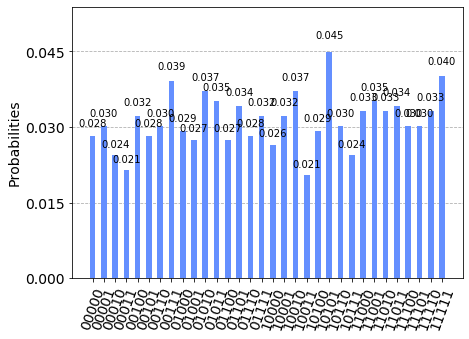

In [47]:
# Plot the result
from qiskit.visualization import plot_histogram

plot_histogram(result.get_counts(circuit))

### Cost function evaluation

So we have been able to prepare a circuit for the ansatz of our optimal solution and we have evaluated it 1024 times, observing that all the possible outcomes are represented almost uniformly.

However, if we want to optimize the 15 rotation angles we introduced to obtain the optimal solution, this is not enough: to decide if our current solution is good enough or we need more iterations to tune its paramters, we need to evaluate its cost function.

Since we are evaluating many times (1024 in our case) the cost function, we will have many values to deal with and we can choose among different figures of merit to extract a quantitative evaluation of the goodness of the current solution.
The more intuitive and naive is the mean value, which we implement here.

Using this figure of merit, our best solution will be the one giving the smallest cost function value.

In [48]:
# Compute the value of the cost function

# results: the results dictionary in the outcome of the circuit measurement
# weights: the original QUBO matrix
def cost_function_C(results, weights):
    
    # the eigenstates obtained by the evaluation of the circuit
    eigenstates = list(results.keys())
    
    # how many times each eigenstate has been sampled
    abundancies = list(results.values())
    
    # number of shots 
    shots = sum(results.values())
    
    # initialize the cost function
    cost = 0
    
    for k in range(len(eigenstates)):
        # ndarray of the digits extracted from the eigenstate string 
        x = np.array([int(num) for num in eigenstates[k]])
        # Cost function due to the k-th eigenstate
        cost = cost + x.dot(W.dot(1-x)) * abundancies[k]
    
    return -cost / shots

In [49]:
# The cost function given by the ansatz 
ansatz_cost = cost_function_C(result.get_counts(), W)
print(ansatz_cost)

-5.0224609375


### Optimizer

Now that we have an ansatz and we have defined our cost function, we want to use a classical optimizer to find the rotation angles that we need to obtain the solution of our problem.

To do so, we have to define the ansatz as a parametric circuit, where the rotation angles of the RY gates are not given as numbers, but appear only as parameters that can be passed to the function that generates the circuit. 

This is not the only technical detail we have to consider, since in order to use the classical optimizer as it is defined in scipy libraries (https://docs.scipy.org/doc/scipy/reference/optimize.minimize-cobyla.html), it is a good idea to include the creation and execution of the circuit inside the function that evaluates its cost.

Once also this change to the cost function definition is implemented, we can finally call the optimizer to get the angles that rotates our ansatz into the solution of the problem.

For this problem, we are using the Constrained optimization by linear approximation (COBYLA), a derivative-free, numerical optimization method used for constrained problem (https://en.wikipedia.org/wiki/COBYLA).

In [11]:
# Write the circuit as a parametric function
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

def VQE_circuit(theta, n, depth): 
    """Creates a variational-form RY ansatz.
    
    theta: (depth+1 x n) matrix of rotation angles,
    n: number of qbits,
    depth: number of layers.
    """
        
    if len(theta.ravel()) != ((depth+1) * n):        
        raise ValueError("Theta cannot be reshaped as a (depth+1 x n) matrix")

    theta.shape = (depth + 1, n)

    # Define the Quantum and Classical Registers
    q = QuantumRegister(n)
    c = ClassicalRegister(n)

    # Build the circuit for the ansatz
    circuit = QuantumCircuit(q, c)

    # Put all the qbits in the |+> state
    for i in range(n):
        circuit.ry(theta[0,i],q[i])
    circuit.barrier()
    
    # Now introduce the z-gates and RY-gates 'depth' times
    for j in range(depth):
        # Apply controlled-z gates
        for i in range(n-1):
            circuit.cz(q[i], q[i+1])

        # Introduce RY-gates
        for i in range(n):
            circuit.ry(theta[j+1,i],q[i])
        circuit.barrier()
    
    # Close the circuit with qbits measurements
    circuit.measure(q, c)
    
    return circuit    

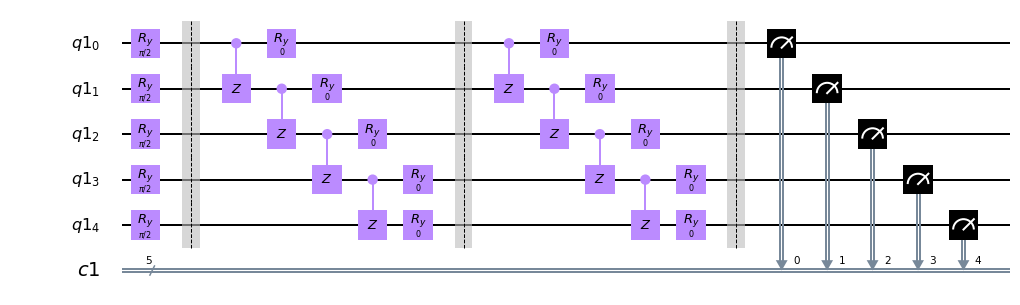

In [12]:
# Draw an example circuit
theta = np.array([[PI/2,PI/2,PI/2,PI/2,PI/2],
                  [0.,0.,0.,0.,0.,],
                  [0.,0.,0.,0.,0.,]])

n_qbits = 5 
depth   = 2

VQE_circuit(theta, 5, 2).draw(output = 'mpl')

In [13]:
# Include the creation and execution of the circuit inside the function
# that computes the value of its cost

# In case you want to use a real quantum device as backend
from qiskit import IBMQ

def cost_function_cobyla(params, 
                         weights,   # = W, 
                         n_qbits,   # = 5, 
                         depth,     # = 2,
                         shots,     # = 1024
                         backend_name = 'qasm_simulator',
                         verbosity    = False):
    """Creates a circuit, executes it and computes the cost function.
    
    params: ndarray with the values of the parameters to be optimized,
    weights: the original QUBO matrix of the problem,
    n_qbits: number of qbits of the circuit,
    depth: number of layers of the ciruit,
    shots: number of evaluations of the circuit state,
    verbosity: activate/desactivate some control printouts.
    
    The function calls 'VQE_circuit' to create the circuit, then
    evaluates it and compute the cost function.
    """
    
    if (verbosity == True):
        print("Arguments:")
        print("params  = \n", params)
        print("weights = \n", weights)
        print("qbits   = ", n_qbits)
        print("depth   = ", depth)
        print("shots   = ", shots)
        print("backend = ", backend_name)
    
    circuit = VQE_circuit(params, n_qbits, depth)
    circuit.draw(output = "mpl")
    
    if backend_name == 'qasm_simulator':
        backend = Aer.get_backend('qasm_simulator')
    else:
        provider = IBMQ.load_account()
        backend = provider.get_backend(backend_name)
    
    # Execute the circuit on a simulator
    job = execute(circuit, 
                  backend = backend, 
                  shots   = shots)
    results = job.result()
    
    # the eigenstates obtained by the evaluation of the circuit
    eigenstates = list(results.get_counts().keys())
    
    # how many times each eigenstate has been sampled
    abundancies = list(results.get_counts().values())
    
    # number of shots 
    shots = sum(result.get_counts().values())
    
    # initialize the cost function
    cost = 0
    
    for k in range(len(eigenstates)):
        # ndarray of the digits extracted from the eigenstate string 
        x = np.array([int(num) for num in eigenstates[k]])
        # Cost function due to the k-th eigenstate
        cost = cost + x.dot(W.dot(1-x)) * abundancies[k]
    
    if (verbosity == True):
        print("cost = ", -cost/shots)

    job     = None
    results = None
    circuit = None
    
    return -cost / shots

In [14]:
# Scipy implementation of the COBYLA optimizer

from scipy.optimize import minimize

# Initial rotation angles of the RY ansatz
theta = np.array([[PI/2,PI/2,PI/2,PI/2,PI/2],
                  [0.,0.,0.,0.,0.,],
                  [0.,0.,0.,0.,0.,]])

WEIGHTS = W
N_QBITS = 5
DEPTH   = 2
SHOTS   = 1024
BACKEND = 'qasm_simulator'

# Classical optimizer tuning
res = minimize(fun     = cost_function_cobyla, 
               x0      = theta.ravel(),     # the 'params' argument of 'cost_function_cobyla'
               method  = 'COBYLA',          # we want to use the COBYLA optimization algorithm
               options = {'maxiter': 500},  # maximum number of iterations
               tol     = 0.0001,            # tolerance or final accuracy in the optimization 
               args    = (WEIGHTS, 
                          N_QBITS, 
                          DEPTH, 
                          SHOTS,
                          BACKEND))         # the arguments of 'cost_function_cobyla', except 'params'

In [15]:
# Obtain the output distribution using the final parameters
optimal_circuit = VQE_circuit(res.x, 
                              N_QBITS, 
                              DEPTH)

backend = Aer.get_backend(BACKEND)

counts = execute(optimal_circuit, 
                 backend, 
                 shots = SHOTS).result().get_counts(optimal_circuit)

print("Optimal rotation angles:\n", res.x)
print()

# To trust the optimizer is fine, but it is better to check ;) 
print("Cost function with the optimal angles (according to scipy):", res.fun)
print("Cost function with the optimal angles (actual evaluation):",  cost_function_cobyla(res.x, 
                                                                                          WEIGHTS, 
                                                                                          N_QBITS, 
                                                                                          DEPTH, 
                                                                                          SHOTS))

Optimal rotation angles:
 [[ 1.94850402  1.837819    1.91758058  1.75065645  0.74734513]
 [ 1.67376743 -1.59201151 -0.06955016  1.55112847  1.39545158]
 [ 0.70590762  1.16762973  0.02030831 -0.8564053  -1.23312691]]

Cost function with the optimal angles (according to scipy): -7.7900390625
Cost function with the optimal angles (actual evaluation): -7.8076171875


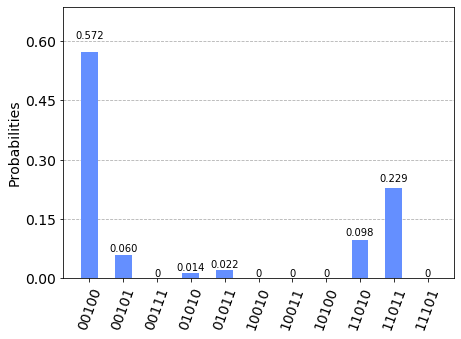

In [16]:
# Plot the result
from qiskit.visualization import plot_histogram

plot_histogram(counts)

### Study of the Number of Shots 

We have seen that the VQE algorithm is able to find the solution of a QUBO problem, at least with the simple max-cut example that we used as benchmark.

But the real challenge for quantum computers is managing to provide reliable solutions to such problems faster than classical computers can do with traditional algorithms.

As we mentioned, one feature of quantum computers is that, in order to have a consistent estimation of the cost function associated to a particular configuration of a circuit and its parameters (rotation angles, in our case), its state has to be evaluated several times. The act of evaluating the state of a circuit is usually defined *shot*.

Here, two opposite forces are acting:
- More shots mean a more detailed and accurate knowledge of the circuit eigenstate composition;
- But more shots mean also more time to reach the optimal solution.

We would like now to perform a systematic study on how the number of shots affects both the convergence to the optimal solution and the time needed to obtain it.

For this, we introduce three quantities:
- To measure the convergence to the optimal solution, we define the overlap of the solution returned by the optimization process with the solution we found using the *brute force* approach, which is Sol = {[00100],[11011]};
- To measure how much it takes to get the solution, we use two quantities:
    - The time taken by the algorithm to carry out the optimization process, in seconds;
    - The number of evaluations of the cost function times the number of shots. We think this should be a more robust estimator of the computational efficiency, since it corresponds to the number of execution of the ansatz circuit.

In [17]:
# In case you want to use a real quantum device as backend
from qiskit import IBMQ

# Is time a good figure of merit?
# https://stackoverflow.com/questions/27728483/understanding-the-output-of-scipy-optimize-basinhopping

import time
from scipy.optimize import minimize

def time_vs_shots(shots,
                  weights,
                  n_qbits,
                  depth,
                  backend_name,
                  final_eval_shots,
                  verbosity = False):
    """Returns the time taken to solve a VQE problem
    as a function of the shots.    
    
    Input parameters:
    shots: number of evaluations of the circuit state,
    weights: the original QUBO matrix of the problem,
    n_qbits: number of qbits of the circuit,
    depth: number of layers of the ciruit,
    backend_name: the name of the device where the optimization will be performed,
    final_eval_shots: number of shots for the evaluation of the optimized circuit,
    verbosity: activate/desactivate some control printouts.
    
    Output:
    elapsed_time: time taken for the optimization (in seconds)
    counts: the results of the optimization
    shots: the 'shots' input parameter (it may be useful for analysis)
    """
    
    # Create the rotation angles for the ansatz
    theta_0       = np.repeat(PI/2, n_qbits)
    theta_0.shape = (1, n_qbits)
    theta_1       = np.zeros((depth, n_qbits))
    theta         = np.concatenate((theta_0, theta_1), axis = 0) 
    
    # Time starts with the optimization
    start_time = time.time()

    # Classical optimizer tuning
    res = minimize(fun     = cost_function_cobyla, 
                   x0      = theta.ravel(),     # the 'params' argument of 'cost_function_cobyla'
                   method  = 'COBYLA',          # we want to use the COBYLA optimization algorithm
                   options = {'maxiter': 500},  # maximum number of iterations
                   tol     = 0.0001,            # tolerance or final accuracy in the optimization 
                   args    = (weights, 
                              n_qbits, 
                              depth, 
                              shots,
                              backend_name))    # the arguments of 'cost_function_cobyla', except 'params'

    # Time stops when the optimization stops
    end_time = time.time()
    
    # Total time taken for the optimization
    elapsed_time = end_time - start_time 

    # Number of cost function evaluations during the optimization
    n_func_evaluations = res.nfev

    # Obtain the output distribution using the final parameters
    optimal_circuit = VQE_circuit(res.x, 
                                  n_qbits, 
                                  depth)

    # Define the backend for the evaluation of the optimal circuit
    # - in case it is a simulator
    if backend_name == 'qasm_simulator':
        backend = Aer.get_backend('qasm_simulator')
    # - in case it is a real quantum device
    else:
        provider = IBMQ.load_account()
        backend = provider.get_backend(backend_name)

    # Get the results from the circuit with the optimized parameters    
    counts = execute(optimal_circuit, 
                     backend, 
                     shots = final_eval_shots).result().get_counts(optimal_circuit)
    
    # Freeing memory???
    res             = None    
    optimal_circuit = None
    theta_0         = None
    theta_1         = None
    theta           = None
    
    return elapsed_time, counts, shots, n_func_evaluations, final_eval_shots

In [22]:
# Test once

# Variables declaration
WEIGHTS    = W
N_QBITS    = 5
DEPTH      = 2
SHOTS      = 512
BACKEND    = 'qasm_simulator'
FINAL_EVAL = 8192

In [52]:
# Execute
test_once = time_vs_shots(SHOTS,
                  WEIGHTS,
                  N_QBITS,
                  DEPTH,
                  BACKEND,
                  FINAL_EVAL) 

# Output object structure:
# a[0]: elapsed time
# a[1]: dictionary with {'eigenstate': frequency}
# a[2]: number of shots
# a[3]: number of cost function evaluation
# a[4]: shots used in the evaluation of the optimal circuit
test_once

(41.090174198150635,
 {'01110': 52,
  '00100': 6559,
  '10111': 1,
  '11010': 4,
  '00101': 9,
  '01100': 342,
  '00010': 4,
  '01101': 1,
  '00011': 1,
  '01010': 92,
  '00111': 6,
  '00000': 40,
  '10100': 253,
  '10110': 29,
  '11011': 1,
  '00110': 793,
  '11100': 4,
  '10000': 1},
 512,
 167,
 8192)

In [53]:
# A small scan, just for testing
import gc

scan_results = []

shots_list = [128, 256, 512, 1024, 2048, 3072, 4096]

for shot in shots_list:
    output = time_vs_shots(shot,
                           WEIGHTS,
                           N_QBITS,
                           DEPTH,
                           BACKEND,
                           FINAL_EVAL) 

    scan_results.append(output)
    del output
    gc.collect()
    
# Normalize results for plotting
for res in scan_results:
    for key, value in res[1].items():
        res[1][key] = res[1][key] / res[4]

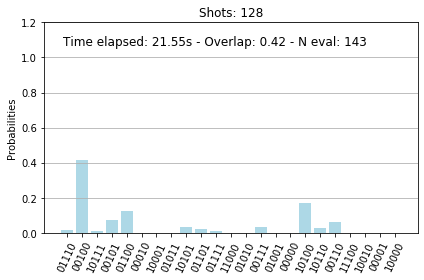

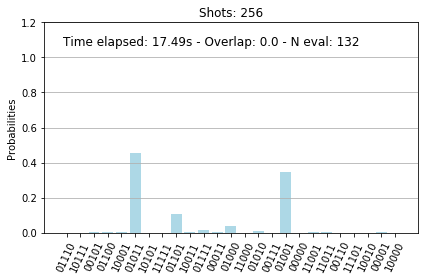

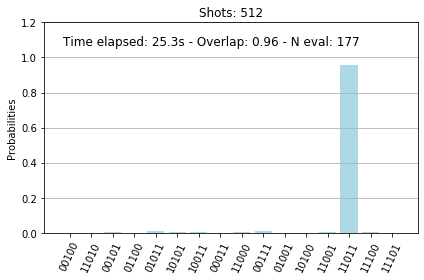

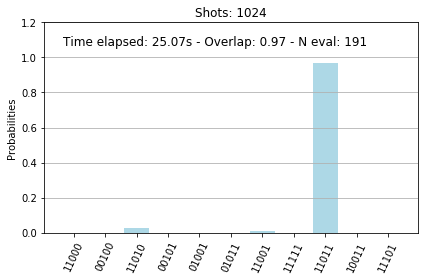

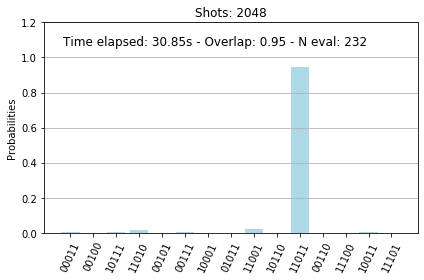

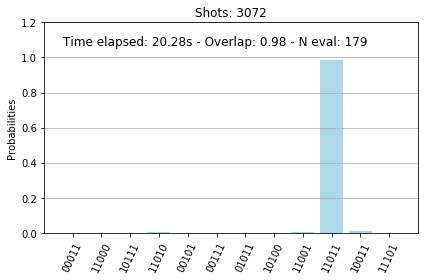

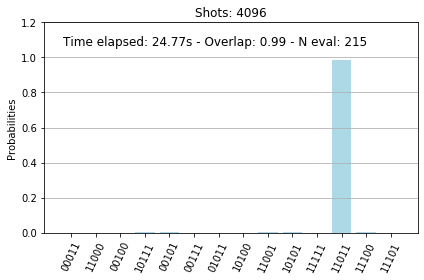

In [54]:
# Plot results
for i in range(len(scan_results)):

    # Compute overlap with correct solution
    # Correct solution = {'11011', '00100'}
    overlap = 0
    for key, value in scan_results[i][1].items():
        if key == '11011' or key == '00100':
            overlap += value
 
    # Start plotting
    fig, ax = plt.subplots()
    barplot = ax.bar(list(scan_results[i][1].keys()), 
                     scan_results[i][1].values(), 
                     color = 'lightblue')

    # Cosmetics
    ax.set_ylim(0.0, 1.2)
    ax.set_ylabel('Probabilities')
    ax.set_xticklabels(list(scan_results[i][1].keys()), rotation='65')

    # Plot information
    time_str    = str(np.around(scan_results[i][0],2))
    shots       = str(scan_results[i][2]) 
    overlap_str = str(np.around(overlap,2))
    n_eval      = str(scan_results[i][3])# * results[i][2])
    
    # Title
    title = "Shots: " + shots
    ax.set_title(title)

    # Result details printed on the plot
    textstr = "Time elapsed: " + time_str + "s - Overlap: " + overlap_str + " - N eval: " + n_eval   
    ax.text(0.05, 0.94, textstr, 
            transform = ax.transAxes, 
            fontsize  = 12,
            verticalalignment='top')    
    
    # Horizontal lines grid
    ax.yaxis.grid()
    
    # Do not cut labels when save as png or pdf
    plt.tight_layout()

    # Save as png and pdf
    filename = "Shots_" + shots
    plt.savefig(filename + '.png')
    plt.savefig(filename + '.pdf')

### Results Interpretation

To try and interpret the results obtained, we can plot some distributions we think can be of interest:
1. Number of cost function evaluation versus shots;
- Time taken to get the solution versus shots;
- Time taken to get the solution versus number of cost function evaluations;
- Time taken to get the solution versus (number of cost function evaluations times shots).
- Time taken to get the solution versus log$_2$(shots);

As we can see in the following plots:
1. The number of cost function evaluations is quite flat versus the number of shots. Considering that the cost function, as we defined it, includes the execution of the circuit for *numberof shots* times, we can conclude that the number of shots does not significantly affect the capability of the optimization algorithm to find a valid solution.
- Taking the previous observation into account, we would expect that increasing the number of shots would require more time to get the solution, since each evaluation of the cost function requires running the ansatz circuit *number of shots* times. However, this is not the case, at least if we look at the second plot, where the time taken to get to the solution is mainly flat versus the number of shots. We can interpret this thinking that the circuit evaluation takes a negligible time with respect to other operations performed by the classical optimizer. On the other hand, we have to take into account that the current results are obtained using a quantum device simulator that runs directly in the laptop used to execute the code. A more proper measure would involve running the whole process using a real quantum device. In that case, however it would be important to take into account in the time estimation, the time spent in the queue (if any) and other possible effects that may inflate our measurements. 
- We observe a direct dependency between time taken to get to the solution and number of evaluations of the cost function. This suggests, again, that the number of evaluations of the cost function is a valid estimator of the rapidity of the algorithm. Also in this case, a proper measurement using a real quantum device seems to be needed to confirm this impression.
- Being the number of cost function evaluations flat versus the number of shots, plotting the elapsed time versus the product of the two quantities is basically the same as plotting the time taken versus the number of shots alone.
- Plotting the elapsed time versus log$_2$(shots) seems to indicate a logaritmic dependence of the time versus the number of shots. This may be checked by running many times the optimization for each number of shots and considering the average. 

In [69]:
# Plot function definition
def scatter_plot(x, y, 
                 title = "", xlabel = "", ylabel = "", save_as = "", 
                 ylim = (-9999, -9999)):
    # Plot declaration
    fig, ax = plt.subplots()
    local_plot = ax.scatter(x = x,
                            y = y)

    # Title
    ax.set_title(title)

    # Cosmetics
    if ylim == (-9999, -9999):
        ax.set_ylim(0.0, 1.5*np.max(y))
    else:    
        ax.set_ylim(ylim)
    ax.set_xlim(0.0, 1.1*np.max(x))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Save as png and pdf
    if save_as != "":
        plt.savefig(save_as + '.png')
        plt.savefig(save_as + '.pdf')

In [70]:
# Prepare the results so that it is easier to plot them

# Create list of times
ntimes = np.array([])
for i in range(len(scan_results)):
    ntimes = np.append(ntimes, scan_results[i][0])
print(ntimes)

# Create list of nfev
nfevs = np.array([])
for i in range(len(scan_results)):
    nfevs = np.append(nfevs, scan_results[i][3])
print(nfevs)

# Create list of shots
nshots = np.array([])
for i in range(len(scan_results)):
    nshots = np.append(nshots, scan_results[i][2])
print(nshots)

NameError: name 'scan_results' is not defined

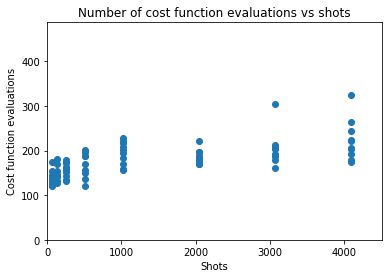

In [71]:
# Cost function evaluations vs shots
scatter_plot(x       = nshots,
             y       = nfevs,
             title   = "Number of cost function evaluations vs shots",
             xlabel  = "Shots",
             ylabel  = "Cost function evaluations",
             save_as = "nfev_vs_shots")

ValueError: x and y must be the same size

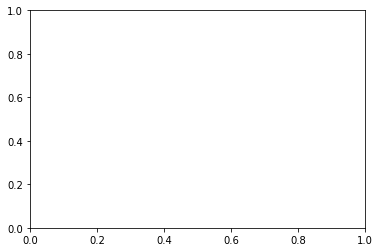

In [72]:
# Elapsed time vs shots
scatter_plot(x       = nshots,
             y       = ntimes,
             title   = "Elapsed time vs shots",
             xlabel  = "Shots",
             ylabel  = "Elapsed time [s]",
             save_as = "time_vs_shots")

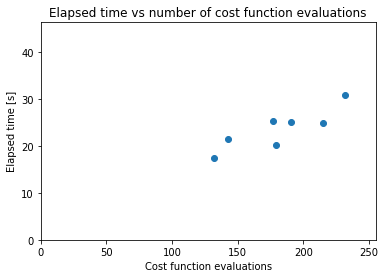

In [59]:
# Elapsed time vs cost function evaluations
scatter_plot(x       = nfevs,
             y       = ntimes,
             title   = "Elapsed time vs number of cost function evaluations",
             xlabel  = "Cost function evaluations",
             ylabel  = "Elapsed time [s]",
             save_as = "time_vs_nfev")

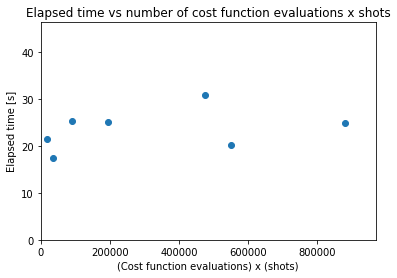

In [60]:
# Elapsed time vs (cost function evaluations x shots)
scatter_plot(x       = nshots*nfevs,
             y       = ntimes,
             title   = "Elapsed time vs number of cost function evaluations x shots",
             xlabel  = "(Cost function evaluations) x (shots)",
             ylabel  = "Elapsed time [s]",
             save_as = "time_vs_nfev_x_shots")

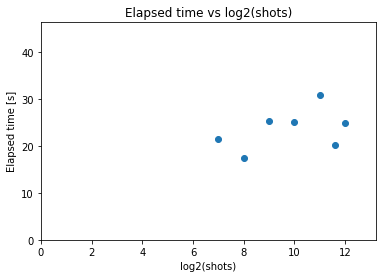

In [61]:
# Elapsed time vs log2(shots)
scatter_plot(x       = np.log2(nshots),
             y       = ntimes,
             title   = "Elapsed time vs log2(shots)",
             xlabel  = "log2(shots)",
             ylabel  = "Elapsed time [s]",
             save_as = "time_vs_log2shots")

### Repeating the Optimization Several Times

Even if the previous results give us a *qualitative* idea of how moving some parameters of the VQE algorithm can affect its rapidity and the goodness of the solution returned, if we want to have some really *quantitative* results, we need to systematically repeat the optimization several times for each value of *shots* that we decide to study.

Additionally, it allows to introduce a different estimator of the goodness of the solution, maybe less intuitive with respect to the overlap, but more suited to the VQE algorithm: given a solution, we compute the cost function associated to each of the (hopefully few) eigenstates contributing to it and taking the one giving the smallest value as the *best candidate* to be considered as the optimal solution.
If we repeat the optimization $N_{rep}$ times and we see that the *best candidate* is actually the optimal solution $N_{b-c}$ times, we can define the fraction of times (let's call it $F_{opt}$) in which we managed to extract from our solution the optimal solution of the problem:

$$ F_{opt} = \dfrac{N_{b-c}}{N_{rep}}$$

This quantity gives us an idea of how many times we should repeat the optimization process if we want to be reasonably sure that at least one of our *best candidates* is also the optimal solution of the problem.

In [25]:
# Compute the value of the cost function of each eigenstate in a solution
# and returns to 'best candidate' eigenstate

# results_dict: the eigenstate-freq dictionary returned by 'time_vs_shots'
# weights: the original QUBO matrix
def best_candidate_finder(results_dict, 
                          weights):
        
    # the eigenstates obtained by the evaluation of the circuit
    eigenstates = list(results_dict.keys())
        
    # initialize the cost function
    min_cost = 0
    best_candidate = 0
    
    for k in range(len(eigenstates)):
        # ndarray of the digits extracted from the eigenstate string 
        x = np.array([int(num) for num in eigenstates[k]])
        # Cost function of to the k-th eigenstate
        cost = x.dot(W.dot(1-x))
        if cost > min_cost:
            min_cost = cost
            best_candidate = eigenstates[k]
    
    return best_candidate

In [26]:
# Function to compute F_opt
def F_opt_finder(results_obj,
                 n_shots,
                 W,
                 opt_sol,
                 n_eigenstates = 1000):
    """Returns the fraction of optimal solutions.
    
    Given the object returned by 'time_vs_shots',
    computes the fraction of best_candidates solutions
    which are optimal solutions.
    
    Inputs:
    results_obj: the object returned by 'time_vs_shots',
    n_shots: the 'number of shots' to investigate,
    W: the original QUBO matrix,
    opt_sol: list of the optimal solutions to the problem,
    n_eigenstates: maximum number of eigenstates in a solution.
    """
    # Initialize the counter of repetitions for the
    # selected number of shots
    N_rep = 0
    # Initialize the counter of best candidates which 
    # are optimal solutions    
    N_bc  = 0
    # Scan all the entries of the object
    for res in results_obj:
        # Select only the entries corresponding to 
        # the selected number of shots
        if res[2] == n_shots:
            # If the number of shots is the one we want to check,
            # sum 1 to the number of repetitions
            N_rep += 1
            # Find best candidate
            bc = best_candidate_finder(res[1], W)
            # best candidate must contain the optimal solution
            if bc in opt_sol:
                # best candidate must have less than 'n_eigenstates' eigenstates
                if len(res[1]) < n_eigenstates:
                    N_bc += 1
    # Initialize output value
    F_opt = 0
    # If N_rep is not 0, return the fraction of best candidates
    # which are also optimal solutions
    if N_rep != 0:
        F_opt = N_bc / N_rep
    else:
        print("The number of shots selected is not present")
    return F_opt    

In [27]:
# We can save the results to produce them once and analyze them later
#https://stackoverflow.com/questions/4529815/saving-an-object-data-persistence
    
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as output:  
        # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)   
        print("Object saved as", filename)

In [6]:
# This function is useful to check the memory usage
# https://stackoverflow.com/a/1094933/1870254

import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [28]:
# A small scan, but we can get some results

from sys import getsizeof
import gc

N_repetitions = 10
shots_list = [64] # [128, 256, 512, 1024, 2048, 3072, 4096]

for shot in shots_list:
    results_current = []
    output = 0
    file_name = "Scan_" + str(shot) + ".pkl"
    for rep in range(N_repetitions): 
        output = time_vs_shots(shot,
                               WEIGHTS,
                               N_QBITS,
                               DEPTH,
                               BACKEND,
                               FINAL_EVAL) 
        
        print("Done with", str(shot), "shots, repetition", rep)
        results_current.append(output)
        del output
        gc.collect()

#        # Check which variables are filling all the memory
#        print("locals")
#        for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                         key= lambda x: -x[1])[:5]:
#            print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
#            
#        print("globals")
#        for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
#                         key= lambda x: -x[1])[:5]:
#            print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
#
#        print("dir")
#        for name, size in sorted(((name, sys.getsizeof(name)) for name in dir()),
#                         key= lambda x: -x[1])[:5]:
#            print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
                       
    save_object(results_current, file_name) 
    results_current = None

Done with 64 shots, repetition 0
Done with 64 shots, repetition 1
Done with 64 shots, repetition 2
Done with 64 shots, repetition 3
Done with 64 shots, repetition 4
Done with 64 shots, repetition 5
Done with 64 shots, repetition 6
Done with 64 shots, repetition 7
Done with 64 shots, repetition 8
Done with 64 shots, repetition 9
Object saved as Scan_64.pkl


In [2]:
# Load results
import pickle

load_shots_list = [64, 128, 256, 512, 1024, 2048, 3072, 4096]

scan = []

for shot in load_shots_list:
    load_file_name = "Scan_" + str(shot) + ".pkl"
    with open(load_file_name, 'rb') as input:
        for pick in pickle.load(input): 
            scan.append(pick)

# Normalize results for plotting
for res in scan:
    for key, value in res[1].items():
        res[1][key] = res[1][key] / res[4]

In [3]:
print("Percentage of solutions containing the optimal solution:")
print()
for shot in load_shots_list:
    frac = F_opt_finder(scan, shot, W, ['00100', '11011'])
    print("Case {0} shots: {1}%".format(shot,frac*100))

Percentage of solutions containing the optimal solution:

Case 64 shots: 100.0%
Case 128 shots: 100.0%
Case 256 shots: 100.0%
Case 512 shots: 100.0%
Case 1024 shots: 100.0%
Case 2048 shots: 100.0%
Case 3072 shots: 100.0%
Case 4096 shots: 100.0%


The results of the study suggest that for the simple problem we are considering, all the optimizations in which the circuit is measured at least 64 times per iteration, provide a solution containing the optimal solution. 

### Results Interpretation with Several Optimizations

Now that we have produced 10 optimization for each choice of the number of shots, we can repeat the plots of the *Results Interpretation* section, in this case considering the average of the different quantities, to see if we observe some significant differences.

In [4]:
# Prepare the results so that it is easier to plot them

# Create list of times
ntimes = np.array([])
for i in range(len(scan)):
    ntimes = np.append(ntimes, scan[i][0])
#print(ntimes)

# Create list of nfev
nfevs = np.array([])
for i in range(len(scan)):
    nfevs = np.append(nfevs, scan[i][3])
#print(nfevs)

# Create list of shots
nshots = np.array([])
for i in range(len(scan)):
    nshots = np.append(nshots, scan[i][2])
#print(nshots)

# Create list of number of eigenstates in the solution
neigenst = np.array([])
for i in range(len(scan)):
    neigenst = np.append(neigenst, len(scan[i][1]))
#print(neigenst)

# Create list of cost function values
ncost = np.array([])
for i in range(len(scan)):
    ncost = np.append(ncost, cost_function_C(scan[i][1], W))
#print(ncost)

In [5]:
# Put the lists in a dataframe
import pandas as pd

df = pd.DataFrame(list(zip(ntimes, nfevs, nshots, neigenst, ncost)), 
               columns =['time', 'nfevs', 'shots', 'eigenstates', 'cost_func'])

df.head(5)

,time,nfevs,shots,eigenstates,cost_func
0,24.862608,175.0,64.0,30.0,-6.427490
1,18.060896,142.0,64.0,31.0,-6.261475
2,16.167479,130.0,64.0,30.0,-5.983398
3,17.568885,133.0,64.0,30.0,-5.528564
4,19.139624,139.0,64.0,29.0,-5.931274


In [6]:
# Group by shots and average
df_plot = df.groupby(['shots']).mean()
df_plot.reset_index(level=0, inplace=True)
df_plot

,shots,time,nfevs,eigenstates,cost_func
0,64.0,17.725865,140.1,29.5,-6.052307
1,128.0,22.009169,147.1,26.7,-6.531226
2,256.0,24.298621,157.2,25.0,-6.967700
3,512.0,26.420003,170.6,21.6,-7.316638
4,1024.0,29.930701,193.9,18.1,-7.359229
5,2048.0,29.868217,186.9,15.3,-7.717566
6,3072.0,31.629773,203.9,13.4,-7.829980
7,4096.0,35.715563,223.4,8.5,-7.980127


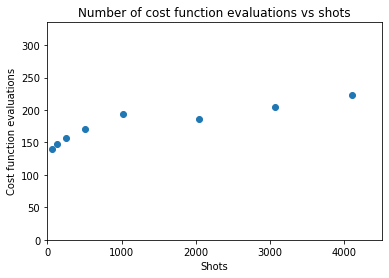

In [7]:
# Cost function evaluations vs shots
scatter_plot(x       = df_plot.shots,
             y       = df_plot.nfevs,
             title   = "Number of cost function evaluations vs shots",
             xlabel  = "Shots",
             ylabel  = "Cost function evaluations",
             save_as = "nfev_vs_shots_avg10")

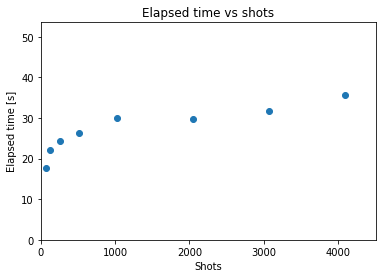

In [8]:
# Elapsed time vs shots
scatter_plot(x       = df_plot.shots,
             y       = df_plot.time,
             title   = "Elapsed time vs shots",
             xlabel  = "Shots",
             ylabel  = "Elapsed time [s]",
             save_as = "time_vs_shots_avg10")

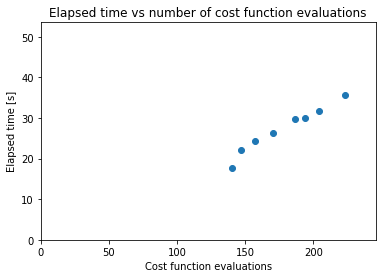

In [9]:
# Elapsed time vs cost function evaluations
scatter_plot(x       = df_plot.nfevs,
             y       = df_plot.time,
             title   = "Elapsed time vs number of cost function evaluations",
             xlabel  = "Cost function evaluations",
             ylabel  = "Elapsed time [s]",
             save_as = "time_vs_nfev_avg10")

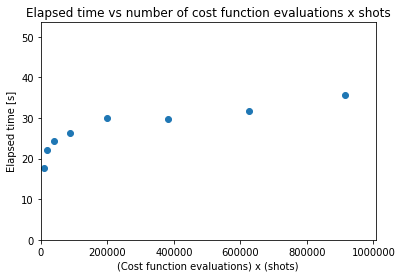

In [10]:
# Elapsed time vs (cost function evaluations x shots)
scatter_plot(x       = df_plot.shots*df_plot.nfevs,
             y       = df_plot.time,
             title   = "Elapsed time vs number of cost function evaluations x shots",
             xlabel  = "(Cost function evaluations) x (shots)",
             ylabel  = "Elapsed time [s]",
             save_as = "time_vs_nfev_x_shots_avg10")

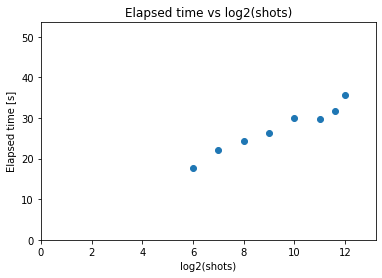

In [11]:
# Elapsed time vs log2(shots)
scatter_plot(x       = np.log2(df_plot.shots),
             y       = df_plot.time,
             title   = "Elapsed time vs log2(shots)",
             xlabel  = "log2(shots)",
             ylabel  = "Elapsed time [s]",
             save_as = "time_vs_log2shots_avg10")

### How many eigenstates in the solution?

One additional quantity that we can measure is the number of eigenstates present in the solution. 

In fact, if we want to solve our problem through a *brute force* approach, we have to evaluate all the 32 possible eigenstates to get the corresponding eigenvalue (or cost function). While in this simple case this is not a problem at all, in general this is not a viable choice and this is the reason why VQE could be an interesting algorithm to solve combinatorial problems.

But if the solution provided by VQE is itself nothing more than a superposition of all possible eigenstates, we are gaining nothing.

For this reason, checking the number of eigenstates in the final solution can give significant hints on the quality of the solution returned by the optimization process.

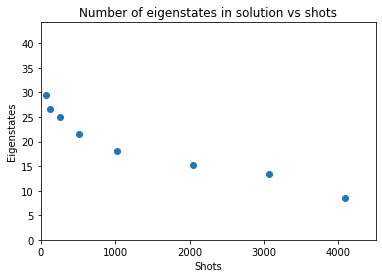

In [12]:
# Number of eigenstates in solution vs shots
scatter_plot(x       = df_plot.shots,
             y       = df_plot.eigenstates,
             title   = "Number of eigenstates in solution vs shots",
             xlabel  = "Shots",
             ylabel  = "Eigenstates",
             save_as = "eigenst_vs_shots_avg10")

Considering this, we can repeat the study on the fraction of valid solutions, but including now the number of eigenstates to decide whether we want to keep the solution or not.

Percentage of solutions containing the optimal solution,  
without any limits on the number of eigenstates:

Case 64 shots: 100.0%
Case 128 shots: 100.0%
Case 256 shots: 100.0%
Case 512 shots: 100.0%
Case 1024 shots: 100.0%
Case 2048 shots: 100.0%
Case 3072 shots: 100.0%
Case 4096 shots: 100.0%


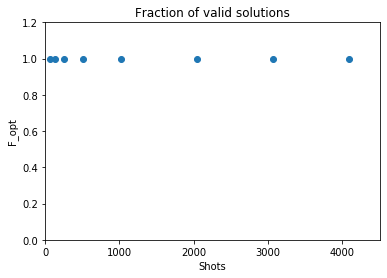

In [13]:
print("""Percentage of solutions containing the optimal solution,  
without any limits on the number of eigenstates:""")
print()
fracs = []
for shot in load_shots_list:
    frac = F_opt_finder(scan, shot, W, ['00100', '11011'], 100)
    print("Case {0} shots: {1}%".format(shot,frac*100))
    fracs.append(frac)
    
scatter_plot(x       = load_shots_list,
             y       = fracs,
             title   = "Fraction of valid solutions",
             xlabel  = "Shots",
             ylabel  = "F_opt",
             save_as = "valid_sol_32",
             ylim    = (0, 1.2))

Percentage of solutions containing the optimal solution and 
having less than 16 eigenstates:

Case 64 shots: 0.0%
Case 128 shots: 10.0%
Case 256 shots: 0.0%
Case 512 shots: 10.0%
Case 1024 shots: 40.0%
Case 2048 shots: 70.0%
Case 3072 shots: 80.0%
Case 4096 shots: 100.0%


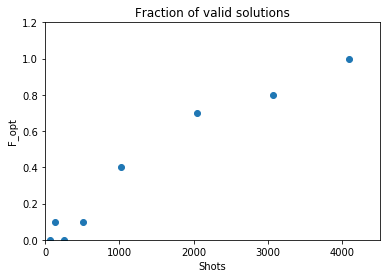

In [14]:
print("""Percentage of solutions containing the optimal solution and 
having less than 16 eigenstates:""")
print()
fracs = []
for shot in load_shots_list:
    frac = F_opt_finder(scan, shot, W, ['00100', '11011'], 16)
    print("Case {0} shots: {1}%".format(shot,frac*100))
    fracs.append(frac)
    
scatter_plot(x       = load_shots_list,
             y       = fracs,
             title   = "Fraction of valid solutions",
             xlabel  = "Shots",
             ylabel  = "F_opt",
             save_as = "valid_sol_16",
             ylim    = (0, 1.2))

Percentage of solutions containing the optimal solution and 
having less than 12 eigenstates:

Case 64 shots: 0.0%
Case 128 shots: 0.0%
Case 256 shots: 0.0%
Case 512 shots: 0.0%
Case 1024 shots: 20.0%
Case 2048 shots: 30.0%
Case 3072 shots: 50.0%
Case 4096 shots: 80.0%


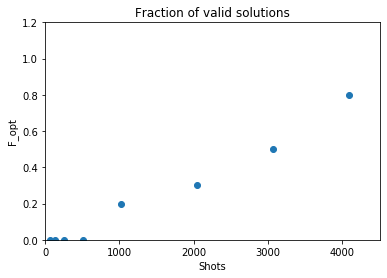

In [15]:
print("""Percentage of solutions containing the optimal solution and 
having less than 12 eigenstates:""")
print()
fracs = []
for shot in load_shots_list:
    frac = F_opt_finder(scan, shot, W, ['00100', '11011'], 12)
    print("Case {0} shots: {1}%".format(shot,frac*100))
    fracs.append(frac)
    
scatter_plot(x       = load_shots_list,
             y       = fracs,
             title   = "Fraction of valid solutions",
             xlabel  = "Shots",
             ylabel  = "F_opt",
             save_as = "valid_sol_12",
             ylim    = (0, 1.2))

Percentage of solutions containing the optimal solution and 
having less than 8 eigenstates:

Case 64 shots: 0.0%
Case 128 shots: 0.0%
Case 256 shots: 0.0%
Case 512 shots: 0.0%
Case 1024 shots: 0.0%
Case 2048 shots: 0.0%
Case 3072 shots: 0.0%
Case 4096 shots: 40.0%


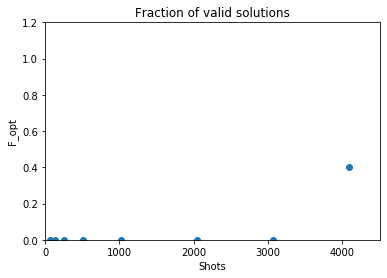

In [16]:
print("""Percentage of solutions containing the optimal solution and 
having less than 8 eigenstates:""")
print()
fracs = []
for shot in load_shots_list:
    frac = F_opt_finder(scan, shot, W, ['00100', '11011'], 8)
    print("Case {0} shots: {1}%".format(shot,frac*100))
    fracs.append(frac)
    
scatter_plot(x       = load_shots_list,
             y       = fracs,
             title   = "Fraction of valid solutions",
             xlabel  = "Shots",
             ylabel  = "F_opt",
             save_as = "valid_sol_8",
             ylim    = (0, 1.2))    

### Best Solution Selection

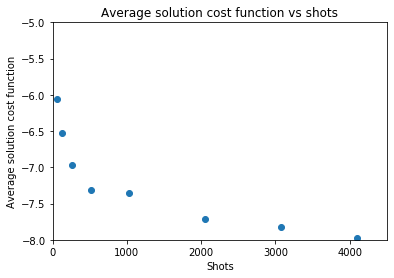

In [17]:
# Average solution cost function vs shots
scatter_plot(x       = df_plot.shots,
             y       = df_plot.cost_func,
             title   = "Average solution cost function vs shots",
             xlabel  = "Shots",
             ylabel  = "Average solution cost function",
             save_as = "cost_vs_shots_avg10",
             ylim    = (-8, -5))

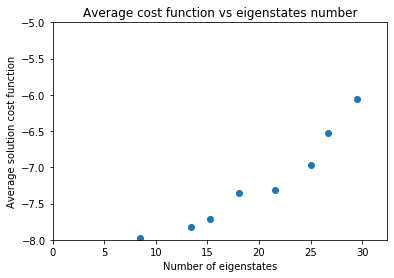

In [18]:
# Average solution cost function vs number of eigenstates in solution
scatter_plot(x       = df_plot.eigenstates,
             y       = df_plot.cost_func,
             title   = "Average cost function vs eigenstates number",
             xlabel  = "Number of eigenstates",
             ylabel  = "Average solution cost function",
             save_as = "cost_vs_eigenst_avg10",
             ylim    = (-8, -5))

In [35]:
# For each number of shots, get the solution giving
# the lowest value of the cost function
df_cost = df.groupby(['shots'])['cost_func']
df_cost_plot = df.copy()

# Group by shots and get the average number of eigenstates
df_eig = df.groupby(['shots'])['eigenstates']
df_eig_plot = df.copy()

df_cost_plot = df_cost_plot.assign(cost_min = df_cost.transform(min),
                                   eig_mean = df_eig.transform(np.mean),
                                   eig_min  = df_eig.transform(np.min))

df_cost_plot = df_cost_plot[df_cost_plot['cost_func'] == df_cost_plot['cost_min']]

df_cost_plot

,time,nfevs,shots,eigenstates,cost_func,cost_min,eig_mean,eig_min
5,16.529243,154.0,64.0,22.0,-7.656128,-7.656128,29.5,22.0
14,24.974285,171.0,128.0,13.0,-7.895386,-7.895386,26.7,13.0
27,26.455978,164.0,256.0,22.0,-7.761475,-7.761475,25.0,21.0
35,28.359070,187.0,512.0,16.0,-7.944336,-7.944336,21.6,12.0
41,31.399109,218.0,1024.0,9.0,-7.959229,-7.959229,18.1,9.0
50,47.372343,221.0,2048.0,10.0,-7.979370,-7.979370,15.3,9.0
69,38.459379,205.0,3072.0,10.0,-7.983154,-7.983154,13.4,10.0
79,37.402647,203.0,4096.0,3.0,-7.998535,-7.998535,8.5,3.0


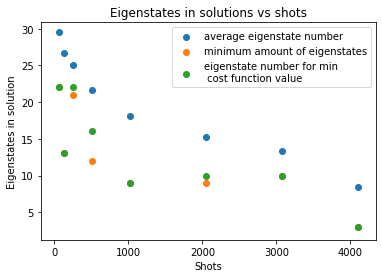

In [38]:
# Plot the number of eigenstates in the solution:
# - mean value (blue)
# - when minimum cost function is selected (green)
# - minimum value (orange)
fig, ax = plt.subplots()

y1 = df_cost_plot.eig_mean
y2 = df_cost_plot.eigenstates
y3 = df_cost_plot.eig_min

avg_plot = ax.scatter(x     = df_cost_plot.shots,
                      y     = y1,
                      label = "average eigenstate number")

min_eig  = ax.scatter(x = df_cost_plot.shots,
                      y = y3,
                      label = "minimum amount of eigenstates")

min_plot = ax.scatter(x = df_cost_plot.shots,
                      y = y2,
                      label = "eigenstate number for min\n cost function value")

ax.set_title("Eigenstates in solutions vs shots")
ax.set_xlabel("Shots")
ax.set_ylabel("Eigenstates in solution")
ax.legend(loc = "upper right")

plot_name = "eig_in_sol"
plt.savefig(plot_name + '.png')
plt.savefig(plot_name + '.pdf')


# A more complex problem? (Work in progress)

### Best Solution Selection

The results of the previous study suggest that for the simple problem we are considering, all the optimizations in which at every iteration the circuit is measured at least 64 times, provide a solution containing the optimal solution. 

In general, we may expect that for more complex problems, just a fraction of the optimizations fulfills this goal.
In that case, we would like to find a way to select a solution that with large probability contains the optimal solution.

For this, we can try building a more complex problem, so that solving it is not as trivial as in the previous case.

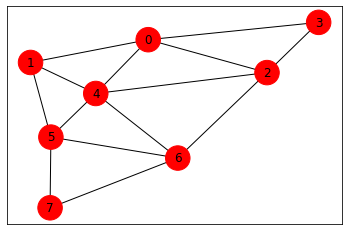

In [118]:
# Tools to handle general graphs
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt 

# Graph parameters 
n2 = 8
V2 = np.arange(0, n, 1)
E2 = [(0, 1, 2.0),
      (0, 2, 1.0),
      (3, 2, 3.0),
      (0, 4, 3.0),
      (4, 2, 1.0),
      (7, 6, 1.0),
      (6, 5, 1.0),
      (5, 4, 6.0),
      (5, 1, 1.0),
      (0, 3, 1.0),
      (6, 2, 1.0),
      (4, 1, 5.0),
      (5, 7, 2.0),
      (4, 6, 1.0)] 

# Generating the graph with 8 nodes
G2 = nx.Graph()
G2.add_nodes_from(V2)
G2.add_weighted_edges_from(E)

# Plot the graph
colors       = ['r' for node in G2.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G2)

nx.draw_networkx(G2, 
                 node_color = colors, 
                 node_size  = 600, 
                 alpha      = 1, 
                 ax         = default_axes, 
                 pos        = pos)


Best solution = [1, 0, 0, 1, 0, 1, 1, 0] cost = 0


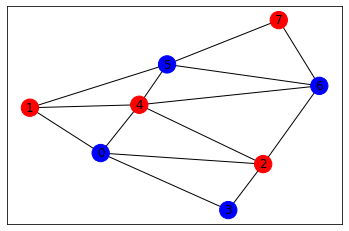

In [119]:
import numpy as np
import networkx as nx

# number of characters
n2 = 8

# W matrix definition
W2 = np.zeros((8,8))

for i in range(len(E2)):
    W[E[i][0]][E[i][1]] = E[i][2] 

best_cost_brute = 0

# computing all possible combinations
for b in range(2**n2):
    # x stores all the 2^n possible combinations of 0 and 1
    # for a vector of length n 
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n2)))]

    # initialize cost function value
    cost = 0
    # scan all possible costs and keep the highest one
    # (now we want to maximize our score!)
    for i in range(n2):
        for j in range(n2):
            cost = cost + W2[i,j]*x[i]*(1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    #print('case = ' + str(x)+ ' score = ' + str(cost))

# Showing results    
colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n2)]
nx.draw_networkx(G2, node_color=colors)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute)) 

In [99]:
# Test once

# Variables declaration
WEIGHTS2    = W2
N_QBITS2    = 8
DEPTH2      = 2
SHOTS2      = 512
BACKEND2    = 'qasm_simulator'
FINAL_EVAL2 = 8192

In [ ]:
# A small scan, but we can get some results

from sys import getsizeof
import gc

N_repetitions = 10
shots_list = [64] # [128, 256, 512, 1024, 2048, 3072, 4096]

for shot in shots_list:
    results_current = []
    output = 0
    file_name = "Scan_8qbits_" + str(shot) + ".pkl"
    for rep in range(N_repetitions): 
        output = time_vs_shots(shot,
                               WEIGHTS,
                               N_QBITS,
                               DEPTH,
                               BACKEND,
                               FINAL_EVAL) 
        
        print("Done with", str(shot), "shots, repetition", rep)
        results_current.append(output)
        del output
        gc.collect()
    save_object(results_current, file_name) 
    results_current = None

Done with 64 shots, repetition 0
Done with 64 shots, repetition 1
Done with 64 shots, repetition 2
Done with 64 shots, repetition 3
Done with 64 shots, repetition 4
Done with 64 shots, repetition 5
Done with 64 shots, repetition 6


In [100]:
# A small scan, just for testing
import gc

scan_results = []

shots_list = [128]#, 256, 512, 1024, 2048, 3072, 4096]

for shot in shots_list:
    output = time_vs_shots(shot,
                           WEIGHTS2,
                           N_QBITS2,
                           DEPTH2,
                           BACKEND2,
                           FINAL_EVAL2) 

    scan_results.append(output)
    del output
    gc.collect()
    
# Normalize results for plotting
for res in scan_results:
    for key, value in res[1].items():
        res[1][key] = res[1][key] / res[4]

In [120]:
print("Percentage of solutions containing the optimal solution:")
print()
frac = F_opt_finder(scan_results, 128, W2, ['10010110','01101001'])
frac

Percentage of solutions containing the optimal solution:



1.0